In [1]:
import torch
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from training.ffn import GestureNet
import pandas as pd


In [2]:
# Check for available devices
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal Performance Shaders (Apple GPU)
    print("Using device: MPS (Metal Performance Shaders)")
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU if available
    print("Using device: CUDA")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using device: CPU")

Using device: MPS (Metal Performance Shaders)


In [3]:
# load model
model_path = "checkpoints/pickles/model_gesture_recog_1.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)
    
model.eval()
model.to(device)

GestureNet(
  (network_stack): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=7, bias=True)
  )
)

In [62]:
train_file_path = "data/train_gesture_data.csv"
eval_file_path = "data/eval_gesture_data.csv"
val_file_path = "data/val_gesture_data.csv"


def load_data(file_path):
    df = pd.read_csv(file_path, index_col=False)
    y = df['label']
    X = df.drop(columns=['label'])
    
    return X, y

# Load training, evaluation, and validation data
X_eval, y_eval = load_data(eval_file_path)
X_val, y_val = load_data(val_file_path)
X_train, y_train  = load_data(train_file_path)

# combine both to get unified testing data
X_test = pd.concat([X_eval, X_val], axis=0)     # concat features
y_test = pd.concat([y_eval, y_val], axis=0)     # concat labels

print(f"combined test data shape: {X_test.shape}")
print(f"combined test labels shape: {y_test.shape}")

# X_test.describe()




combined test data shape: (1387, 63)
combined test labels shape: (1387,)


In [63]:
train_desc = X_train.describe().T
test_desc = X_test.describe().T

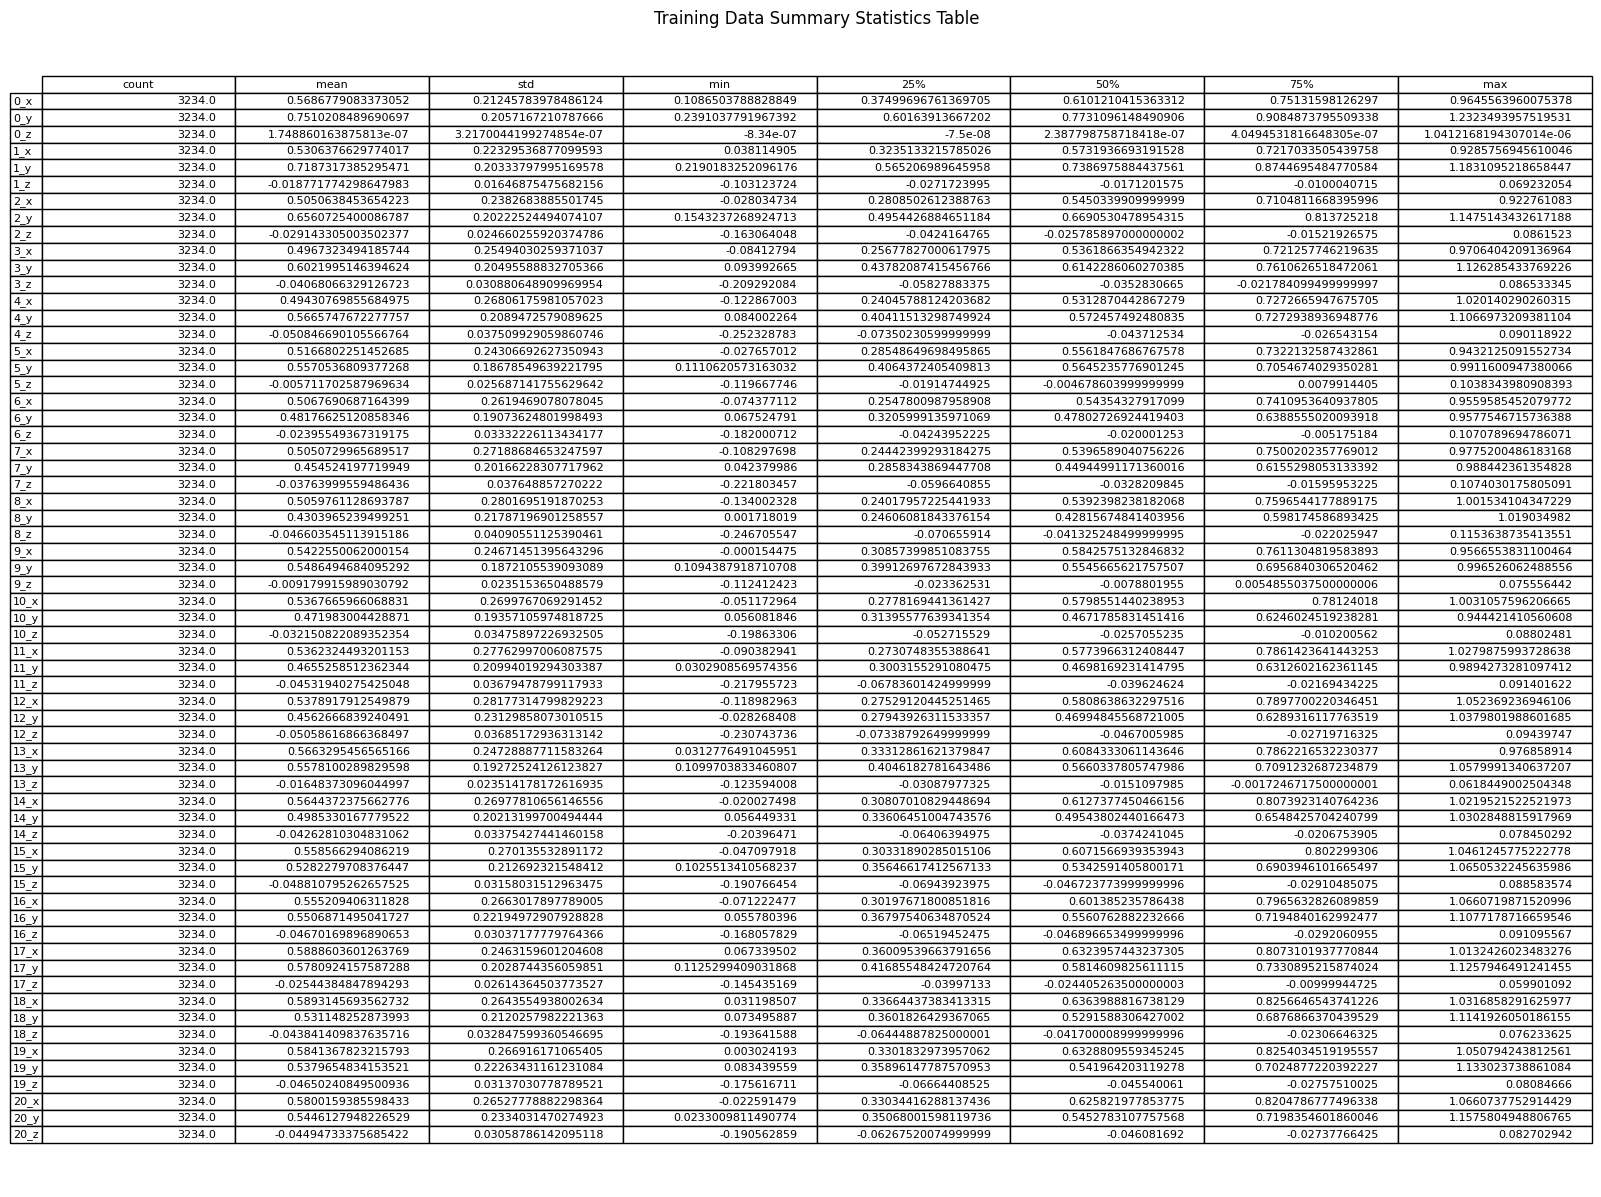

In [64]:
# Plot Training data table
fig, ax = plt.subplots(figsize=(20, 15))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=train_desc.values,
                 colLabels=train_desc.columns,
                 rowLabels=train_desc.index,
                 loc='center')

plt.title("Training Data Summary Statistics Table")
plt.show()

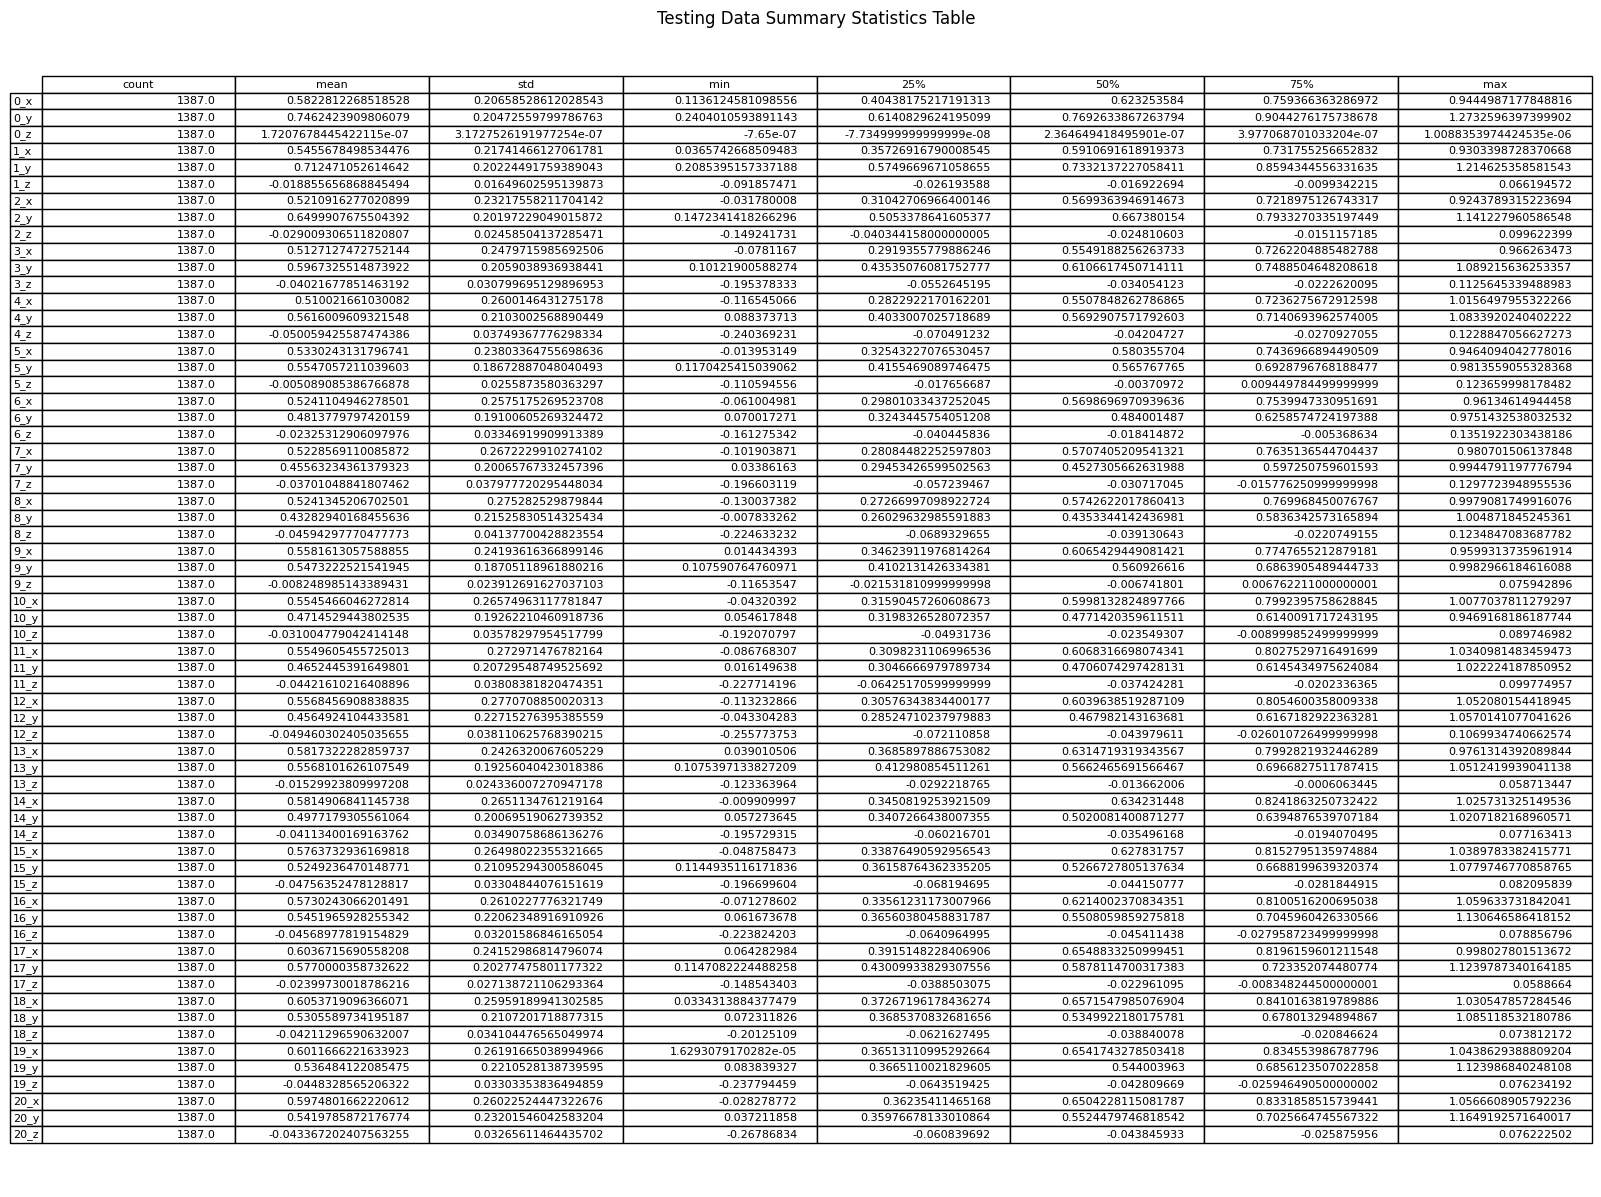

In [65]:
# Plot Testing data table
fig, ax = plt.subplots(figsize=(20, 15))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=test_desc.values,
                 colLabels=test_desc.columns,
                 rowLabels=test_desc.index,
                 loc='center')

plt.title("Testing Data Summary Statistics Table")
plt.show()

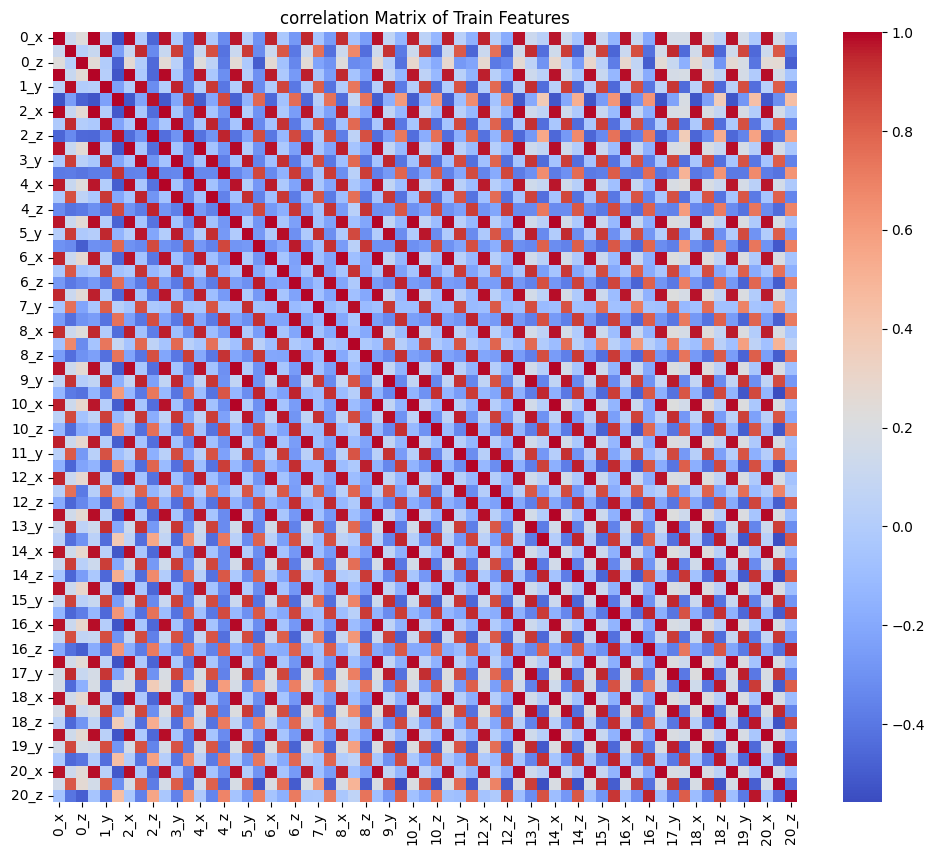

In [66]:
corr_train = X_train.corr()

# plotting correlation matrix of testing data
plt.figure(figsize=(12, 10))
sns.heatmap(corr_train, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("correlation Matrix of Train Features")
plt.show()

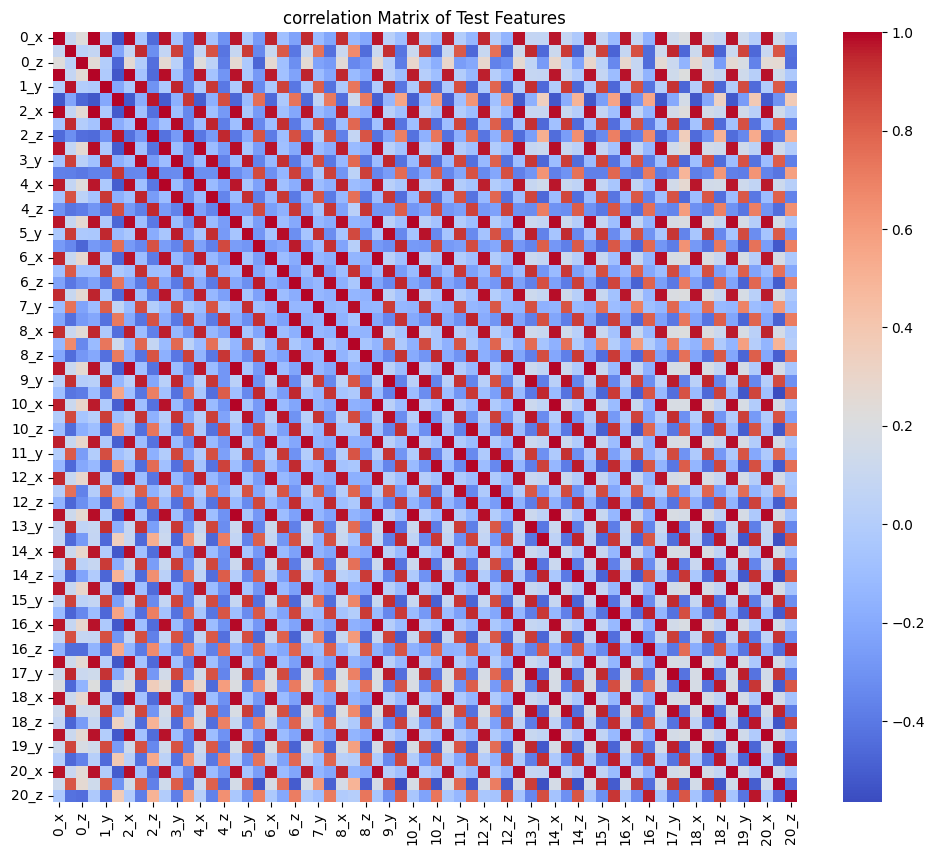

In [7]:

corr_test = X_test.corr()

# plotting correlation matrix of testing data
plt.figure(figsize=(12, 10))
sns.heatmap(corr_test, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("correlation Matrix of Test Features")
plt.show()

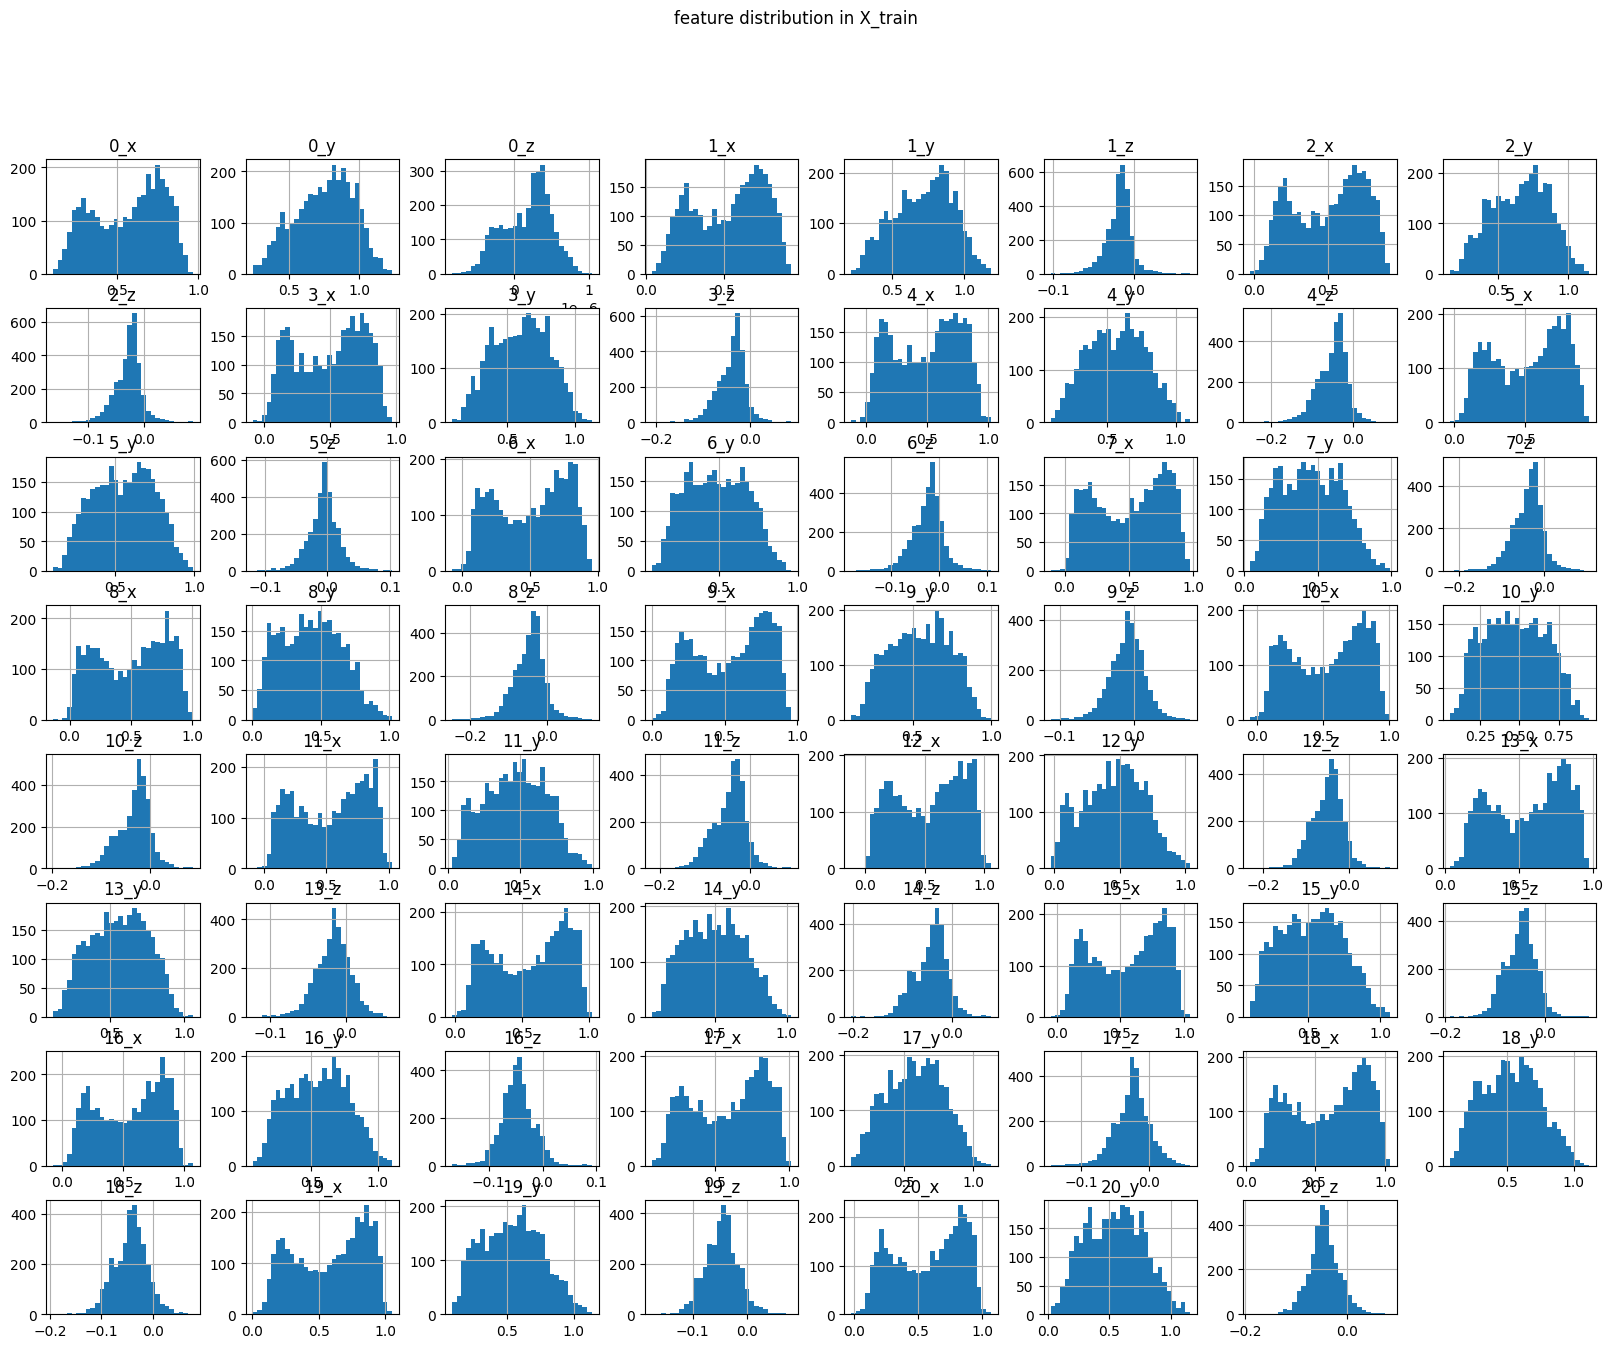

In [67]:
# distribution features in training 
X_train.hist(figsize=(20, 15), bins=30)
plt.suptitle("feature distribution in X_train")
plt.show()

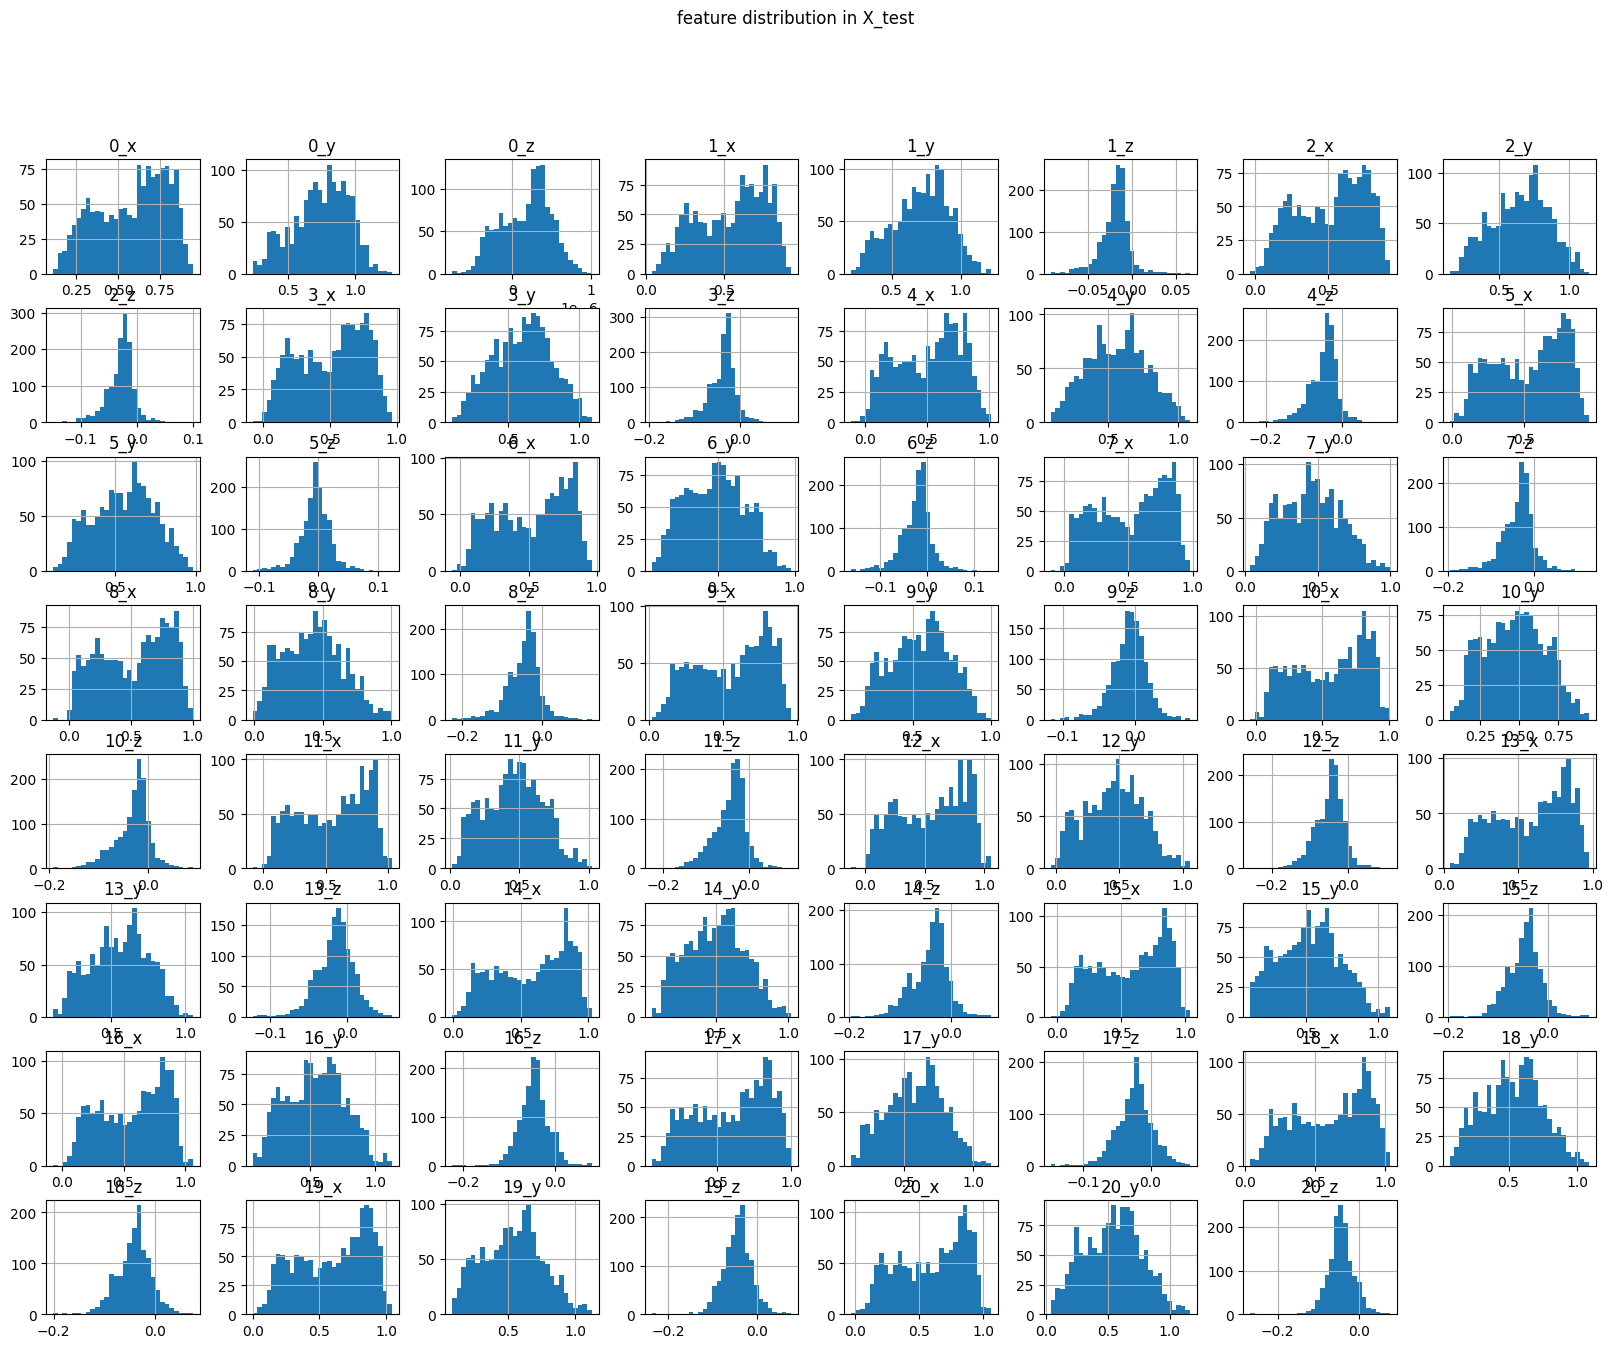

In [9]:
# distribution features in testing
X_test.hist(figsize=(20, 15), bins=30)
plt.suptitle("feature distribution in X_test")
plt.show()

In [69]:
# load StandardScaler from pickle
scaler_path = 'checkpoints/pickles/scaler/scaler_pickle_1.pkl'
with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)

X_test_norm = scaler.transform(X_test)

In [70]:
# creating tensor
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [71]:
# creating dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [72]:
# creating batch loader
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [73]:
# perform predictions on the test data
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # forward pass
        predictions = model(X_batch)
        
        # output predictions
        _, pred_labels = torch.max(predictions, 1)
        
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

In [79]:
# evaluating the model
# 1. classification report
print("Classification Report:")
classif_report = classification_report(all_labels, all_preds, output_dict = True)
classif_report_df = pd.DataFrame(classif_report).T
print(classif_report_df)

Classification Report:
              precision    recall  f1-score      support
0.0            0.988290  0.981395  0.984831   430.000000
1.0            0.888889  0.941176  0.914286   136.000000
2.0            0.978417  0.912752  0.944444   149.000000
3.0            0.932927  0.927273  0.930091   165.000000
4.0            0.879195  0.909722  0.894198   144.000000
5.0            0.965318  0.897849  0.930362   186.000000
6.0            0.895288  0.966102  0.929348   177.000000
accuracy       0.943043  0.943043  0.943043     0.943043
macro avg      0.932618  0.933753  0.932509  1387.000000
weighted avg   0.944621  0.943043  0.943269  1387.000000


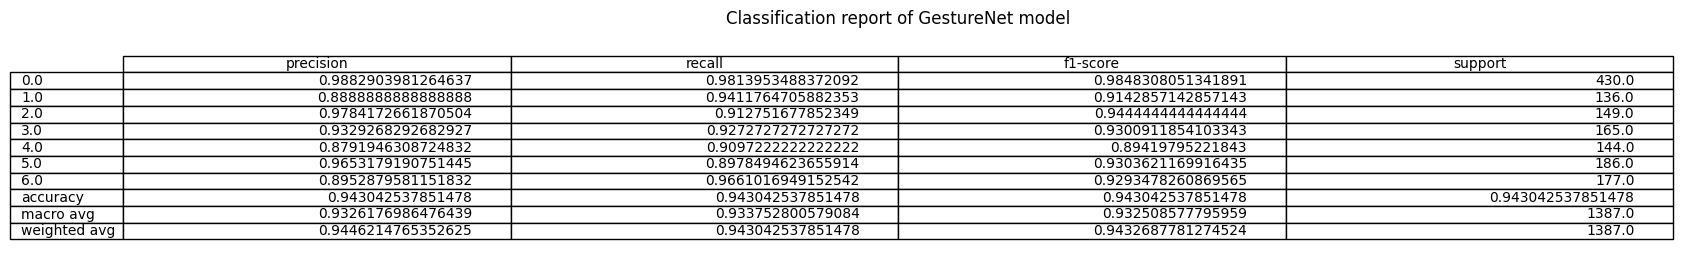

In [82]:
# Plot Testing data table
fig, ax = plt.subplots(figsize=(20, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=classif_report_df.values,
                 colLabels=classif_report_df.columns,
                 rowLabels=classif_report_df.index,
                 loc='center')

plt.title("Classification report of GestureNet model")
plt.show()

In [83]:
# 2. confusion matrix
print("confusion matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

confusion matrix:
[[422   5   2   0   1   0   0]
 [  0 128   1   0   6   1   0]
 [  0  11 136   0   1   0   1]
 [  2   0   0 153  10   0   0]
 [  1   0   0  11 131   0   1]
 [  1   0   0   0   0 167  18]
 [  1   0   0   0   0   5 171]]


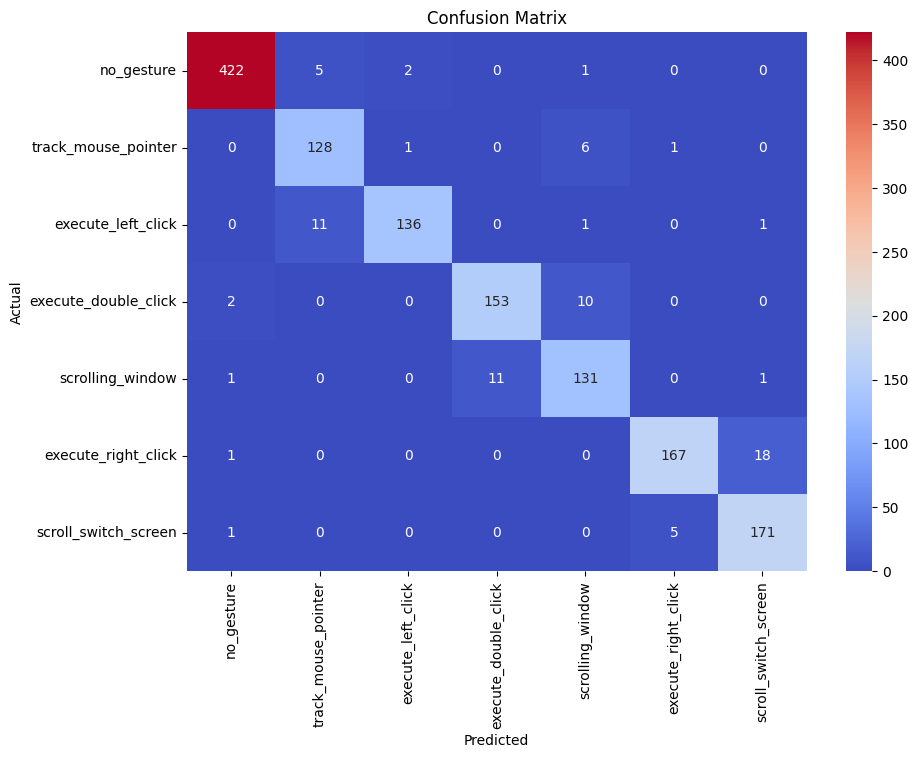

In [84]:
# visualization
gesture_labels ={
    0: "no_gesture",                    # nothing_detected
    1: "track_mouse_pointer",           # index_finger_up
    2: "execute_left_click",            # index_and_thumb_up
    3: "execute_double_click",          # index_and_middle_spaced
    4: "scrolling_window",              # index_and_middle_together
    5: "execute_right_click",           # index_thumb_middle_spaced
    6: "scroll_switch_screen"           # index_thumb_middle_together  NOT SUPPORTED IN MAC
}

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=gesture_labels.values(), yticklabels=gesture_labels.values())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [86]:
# measuring time inference
import time


# sample = torch.tensor(X_test[0], dtype=torch.float32)  # single test sample
sample = X_test_tensor[0].unsqueeze(0)
num_iterations = 100

start_time = time.time()
for _ in range(num_iterations):
    _ = model(sample.to(device))
    
end_time = time.time()

average_time = (end_time - start_time) / num_iterations
print(f"Average inference time per sample: {average_time:.6f} seconds")

Average inference time per sample: 0.000819 seconds


In [87]:
from sklearn.metrics import accuracy_score

class PyTorchModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device
    
    def fit(self, X, y):
        # No fitting needed as the model is already trained
        pass
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, preds = torch.max(outputs, 1)
        return preds.cpu().numpy()
    
    def score(self, X, y):
        preds = self.predict(X)
        return accuracy_score(y, preds)


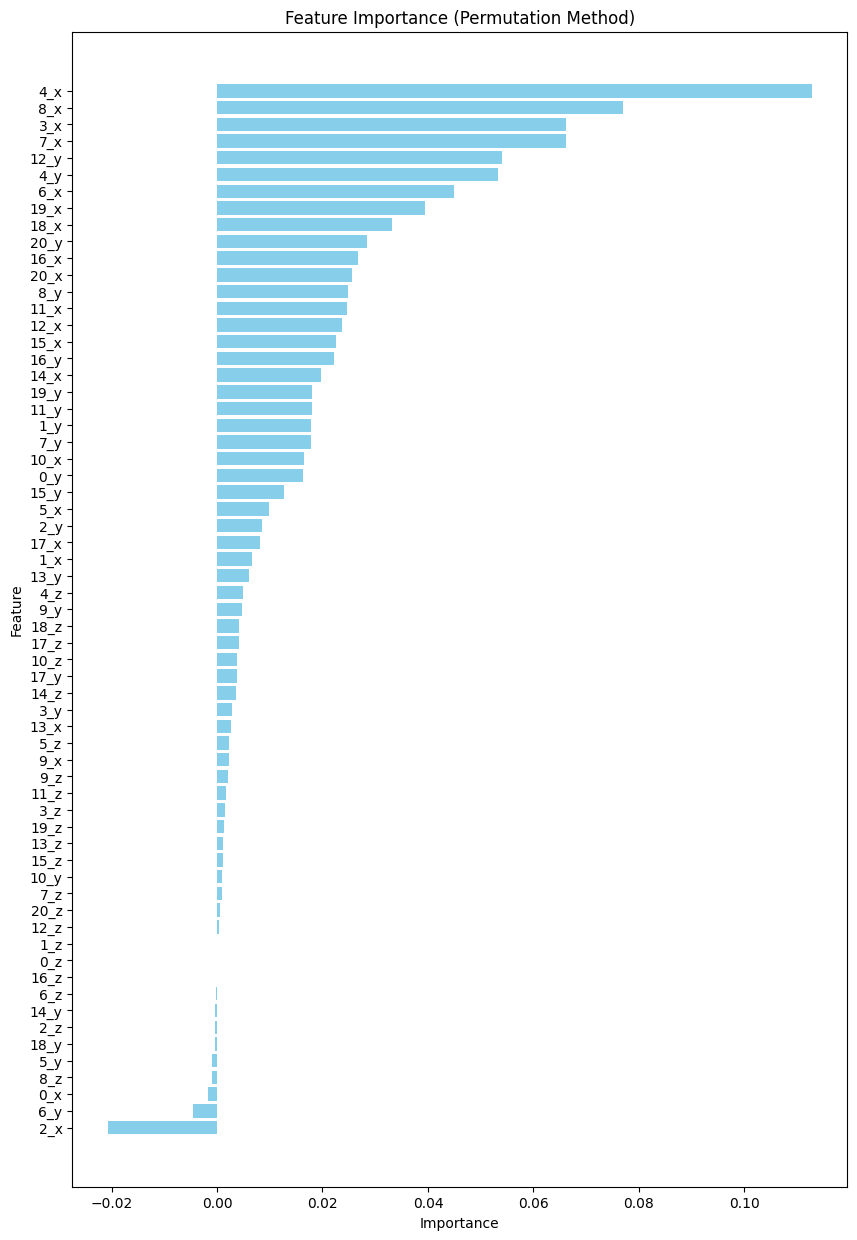

In [88]:
from sklearn.inspection import permutation_importance

# Wrap the trained PyTorch model
model_wrapper = PyTorchModelWrapper(model, device)

# Compute permutation importance
perm_importance = permutation_importance(
    model_wrapper, 
    X_test.values,  # Pass as numpy array
    y_test.values,  # Pass as numpy array
    n_repeats=10, 
    random_state=42
)

# Create a DataFrame for feature importance
feature_names = X_test.columns
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance.importances_mean
})
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# Plot feature importance
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.title("Feature Importance (Permutation Method)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()
